registering..


/home/ima/Studia/miekka_robotyka/elephant_trunk/trunk/lib/python3.10/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/ima/Studia/miekka_robotyka/elephant_trunk/trunk/lib/python3.10/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/home/ima/Studia/miekka_robotyka/elephant_trunk/trunk/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/ima/Studia/miekka_robotyka/elephant_trunk/trunk-agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 1000/1000 [03:16<00:00,  5.08it/s]


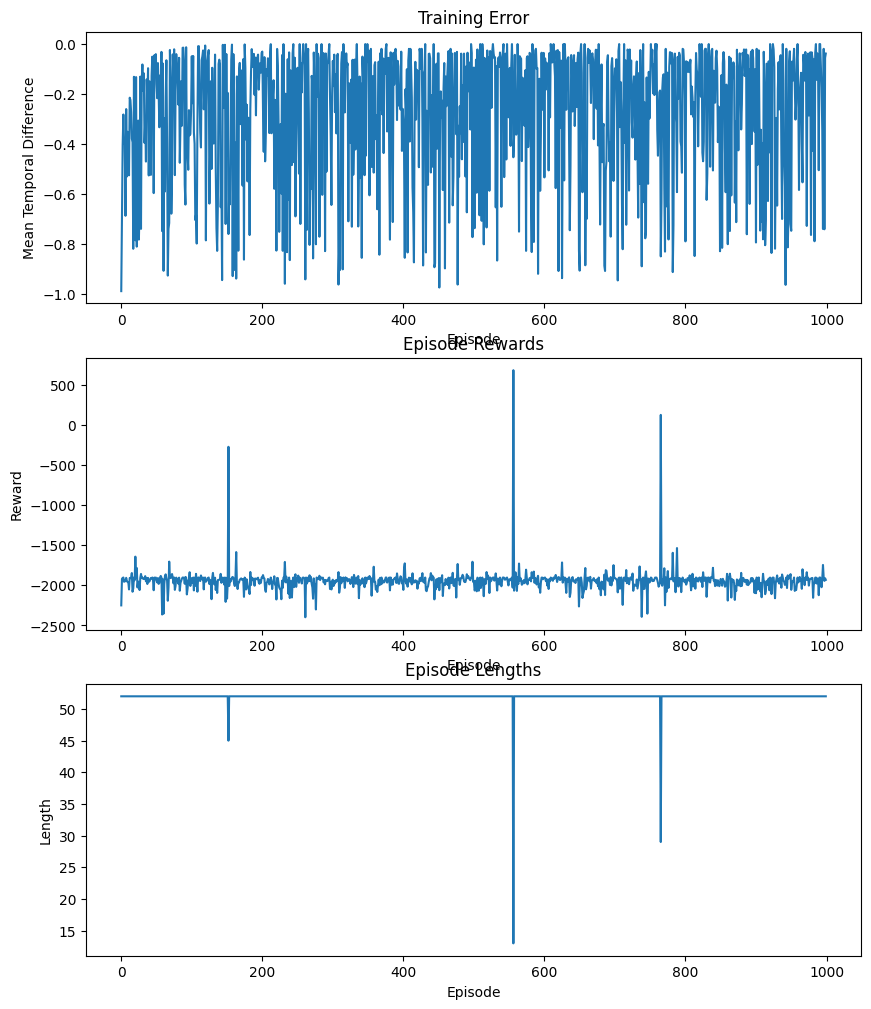

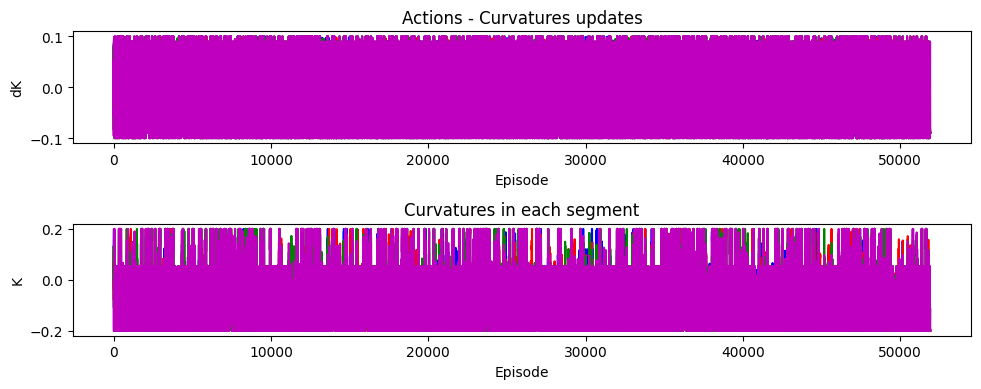

In [1]:
#!/usr/bin/python3.10

#Enable Interactive Plots

%matplotlib inline
%load_ext autoreload
%autoreload 2

import gymnasium as gym
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt
import os
import shutil
from manipulator.trunk_environment import TrunkEnv  # Import TrunkEnv

exec(open("register.py").read()) # register the project

class TrunkAgent:
    def __init__(self, env: gym.Env, learning_rate: float, epsilon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.95, log: bool = False):
        """Initialize a reinforcement learning agent."""
        self.env = env
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []
        self.log = log  # Enable logging if True

        # Discretize the observation space
        N_BINS = 20
        MAX_STEP = 0.2
        self.obs_bins = [
            np.linspace(-20, 20, N_BINS),  # x-effector
            np.linspace(-30, 0, N_BINS),   # y-effector
            np.linspace(-20, 20, N_BINS),  # x-target
            np.linspace(-30, 0, N_BINS),   # y-target
            np.linspace(-MAX_STEP, MAX_STEP, N_BINS),  # k1
            np.linspace(-MAX_STEP, MAX_STEP, N_BINS),  # k2
            np.linspace(-MAX_STEP, MAX_STEP, N_BINS),  # k3
            np.linspace(-MAX_STEP, MAX_STEP, N_BINS)   # k4
        ]

        # Discretize the action space
        ACTION_BINS = 20
        self.action_bins = [
            np.linspace(self.env.action_space.low[i], self.env.action_space.high[i], ACTION_BINS)
            for i in range(self.env.action_space.shape[0])
        ]

        # Initialize Q-table with small random values
        self.q_values = defaultdict(lambda: np.random.uniform(low=-0.01, high=0.01, size=(ACTION_BINS ** self.env.action_space.shape[0])))

    def discretize_observation(self, obs):
        """Discretizes the continuous observation into bins."""
        discrete_obs = tuple(
            np.clip(np.digitize(obs[i], self.obs_bins[i]) - 1, 0, len(self.obs_bins[i]) - 2)
            for i in range(len(obs))
        )
        return discrete_obs

    def discretize_action(self, action):
        """Discretizes a continuous action into bins."""
        discrete_action = tuple(
            np.clip(np.digitize(action[i], self.action_bins[i]) - 1, 0, len(self.action_bins[i]) - 2)
            for i in range(len(action))
        )
        return discrete_action

    def get_action(self, obs):
        """Returns the best action or a random one based on epsilon."""
        if np.random.random() < self.epsilon:
            if self.log:
                print("Exploring: Random action chosen.")
            return self.env.action_space.sample()
        else:
            obs_tuple = self.discretize_observation(obs)
            q_values = self.q_values[obs_tuple]
            best_action_idx = np.random.choice(np.flatnonzero(q_values == q_values.max()))  # Tie-breaking
            best_action = np.array([
                self.action_bins[i][best_action_idx % len(self.action_bins[i])]
                for i in range(len(self.action_bins))
            ])
            if self.log:
                print(f"Exploiting: Best action chosen - {best_action}")
            return best_action

    def update(self, obs, action, reward, terminated, next_obs):
        """Updates a Q-value of an action."""
        tp_obs = self.discretize_observation(obs)
        tp_action = self.discretize_action(action)
        action_idx = np.ravel_multi_index(tp_action, [len(b) for b in self.action_bins])

        tp_next_obs = self.discretize_observation(next_obs)
        future_q_value = (not terminated) * np.max(self.q_values[tp_next_obs])

        # Normalize reward for stability
        normalized_reward = np.clip(reward, -1.0, 1.0)

        temporal_difference = normalized_reward + self.discount_factor * future_q_value - self.q_values[tp_obs][action_idx]
        self.q_values[tp_obs][action_idx] += self.lr * temporal_difference
        self.training_error.append(float(temporal_difference))

        if self.log:
            print(f"Update: TD Error = {temporal_difference}")

    def decay_epsilon(self):
        """Decay epsilon using an exponential schedule."""
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.final_epsilon)
        if self.log:
            print(f"Epsilon decayed to {self.epsilon}")




plotObs = True
# Hyperparameters
learning_rate = 0.05
n_episodes = 1000
start_epsilon = 1.0
final_epsilon = 0.05
epsilon_decay = start_epsilon / (n_episodes)

# Path to the folder
folder_path = "./trunk-agent"

# Clear the folder if it exists
if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove files
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directories
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")
else:
    os.makedirs(folder_path)  # Create folder if it doesn't exist

# Environment setup
env = gym.make("TrunkManipulator-v0", render_mode="rgb_array", max_steps=51, target=[4,-30])
env = gym.wrappers.RecordVideo(env, video_folder="trunk-agent", name_prefix="eval", episode_trigger=lambda x: x == n_episodes or x == 0)
env = gym.wrappers.RecordEpisodeStatistics(env=env,buffer_length=n_episodes)
agent = TrunkAgent(env=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon)

# Training loop
episode_td_errors = []
actions = []
observations = []
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    episode_td_error = []
    while not done:
        action = agent.get_action(obs)
        # print(f"action : {action}")
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(action=action, obs=obs, next_obs=next_obs, reward=reward, terminated=terminated)
        obs = next_obs
        done = terminated or truncated
        episode_td_error.append(agent.training_error[-1])

        actions.append(action) # debug
        observations.append(obs) # debug

        # print(f"state: {obs}")
        # if episode % 100 == 0:
            # print(f"episode : {episode}, action : {action}, observation: {obs} \n")
    episode_td_errors.append(np.mean(episode_td_error))
    agent.decay_epsilon()


# Plotting the training error
plt.close('all')
rolling_mean = np.convolve(episode_td_errors, np.ones(1) / 1, mode='valid')
fig0, ax = plt.subplots(3,1,figsize=(10, 12))
ax[0].plot(rolling_mean)
ax[0].set_title("Training Error")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Mean Temporal Difference")

ax[1].plot(env.return_queue)
ax[1].set_title("Episode Rewards")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Reward")

ax[2].plot(env.length_queue)
ax[2].set_title("Episode Lengths")
ax[2].set_xlabel("Episode")
ax[2].set_ylabel("Length")

if n_episodes < 101 or plotObs:
    fig1, ax1 = plt.subplots(2,1,figsize=(10, 4))
    observations_array = np.array(observations)
    actions_array = np.array(actions)
    ax1[0].plot(actions_array[:,0], '-b')
    ax1[0].plot(actions_array[:,1], '-r')
    ax1[0].plot(actions_array[:,2], '-g')
    ax1[0].plot(actions_array[:,3], '-m')
    ax1[0].set_title("Actions - Curvatures updates")
    ax1[0].set_xlabel("Episode")
    ax1[0].set_ylabel("dK")

    ax1[1].plot(observations_array[:,4], '-b')
    ax1[1].plot(observations_array[:,5], '-r')
    ax1[1].plot(observations_array[:,6], '-g')
    ax1[1].plot(observations_array[:,7], '-m')
    ax1[1].set_title("Curvatures in each segment")
    ax1[1].set_xlabel("Episode")
    ax1[1].set_ylabel("K")
plt.tight_layout()
plt.show()


In [2]:
# Evaluate the agent
total_rewards = []
for _ in range(10):  # Evaluate for 100 episodes
    obs, info = env.reset()
    episode_reward = 0
    done = False
    while not done:
        action = agent.get_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        done = terminated or truncated
    total_rewards.append(episode_reward)
plt.close('all')
print(f"Average reward over 10 evaluation episodes: {np.mean(total_rewards)}")

Average reward over 10 evaluation episodes: -1956.5229869918003


In [3]:
from IPython.display import HTML

obs, info = env.reset()
episode_over = False
while not episode_over:

  action = env.action_space.sample()  # replace with actual agent
  obs, reward, terminated, truncated, info = env.step(action)

  episode_over = terminated or truncated
plt.close('all')

video_path1 = 'trunk-agent/eval-episode-' + str(n_episodes) + '.mp4'
video_path2 = 'trunk-agent/eval-episode-' + str(0) + '.mp4'
# Embed both videos in a single HTML block
HTML(f"""
<div style="display: flex; justify-content: space-around; align-items: center;">
    <video width="640" height="480" controls autoplay loop muted>
      <source src="{video_path2}" type="video/mp4">
      Your browser does not support the video tag.
    </video>
    <p>First Episode</p>
    <video width="640" height="480" controls autoplay loop muted>
      <source src="{video_path1}" type="video/mp4">
      Your browser does not support the video tag.
    </video>
    <p>Last episode</p>
</div>
""")

# Close the environment
